# Simulation of Brownian motion

Vesicles diameters obtained from Nanoparticle Tracking Analyses (NTA).


Notebook good works on google colab.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# -*- coding: utf-8 -*-
"""
  Simulation of Brownian Motion
  vesicles diameters obtained from Nanoparticle Tracking Analyses (NTA)
"""

import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

from scipy.interpolate import interp1d
import os
import pandas as pd
import random

import time


def import_NTA_distribution():
  """
  Import NTA distribution from csv
  """
  dir='./NTA_csv/'
  files = os.listdir(dir)
  dic_nta = {}
  for file in files:
    df = pd.read_csv(dir+file,  header=None, sep=";",decimal=",", dtype=np.float64)
    calka = np.cumsum(df[1])
    dic_nta[file[:3]]=[np.array(df[0]), np.array(df[1])]
  return dic_nta

def normalize(x, y):
  x = np.array(x)
  y = np.array(y)
  calka = np.sum(0.5*(y[0:-1]+y[1:])*(x[1:]-x[0:-1]))
  y = y/calka
  return x, y

def get_NTA_distribution(files_list, vesicles_number=10**4): 
  dic_nta = import_NTA_distribution()
  x_new = np.linspace(10, 400, num=10000, endpoint=True)
  y_new = np.zeros(x_new.shape)
  licznik = 0

  for name in files_list:
    x, y = zip(*sorted(zip(dic_nta[name][0], dic_nta[name][1])))
    x = np.array(x)
    x, y = normalize(x, y)
    f2 = interp1d(x, y)
    y_new += f2(x_new)
    licznik+=1
  y_new/=licznik
  y_new = np.where(y_new<0, 0, y_new)

  sample = random.choices(x_new, y_new, k=vesicles_number) #randomize k values from the set x with weights y
  
  return np.array(sample)*10**-9 # change nm to m


def simulation(files_list, N, tmax, g_k=3E-3, dt =1, t_measurements=[3600, 3600*20]):
  """
  files_list -  file names of csv with NTA (without extension ".csv")
  N - number of vesicles
  tmax - time after which the simulation ends [s]
  g_k - mean drop thickness
  dt - time step [s]
  t_measurements -  the time when we want to draw histograms of the diameters of the attached vesicles

  """

  eta=1E-3
  T=293
  k_B=1.38E-23

  # I draw diameters from the distribution, each vesicle has a random diameter
  dk = get_NTA_distribution(files_list,vesicles_number = N)

  # I determine the diffusion constant for each vesicle
  Dk=k_B*T/(3*np.pi*eta*dk)

  sig=np.sqrt(2*Dk*dt)

  xk=np.random.rand(N)*(g_k) # I draw initial values

  # ------------------------
  # attached vesicles will be marked as 0 in przyczepione
  przyczepione = np.ones((N))

  # how many vesicles were attached in a given time step:
  attached_N=np.zeros(int(tmax/dt))

  attached_populations=[]
  mean_diameter= np.zeros(int(tmax/dt))

  # Simulation ------------------------
  Q=np.random.randn(N)
  for t in range(int(tmax/dt)):
    iq=int(np.random.rand(1)*(N-2)+1)
    Q=np.concatenate((Q[iq:],Q[:iq]))
    xk+= sig*Q*przyczepione

    # bounce a vesicle that is above the upper limit
    xk[np.where(xk>g_k)]=2*g_k-xk[np.where(xk>g_k)]

    # if in this step the exosome touches the surface, I will remove it
    przyczepione[np.where(xk<=0)]= 0

    attached_N[t] = N - np.sum(przyczepione)
    if len(t_measurements)>0:
      if t*dt >= t_measurements[0]:
        t_measurements.pop(0)
        sred_przyczepione = dk[np.where(przyczepione==0)]*10**9 #change m to nm
        attached_populations.append(np.copy(sred_przyczepione))
    
    # diametres
    sred_przyczepione = dk[np.where(przyczepione==0)]*10**9
    mean_diameter[t] = np.mean(sred_przyczepione)

  tt=np.arange(int(tmax/dt))
  t_vec = tt*dt/3600
  return attached_populations, mean_diameter, attached_N/N*100, t_vec



In [9]:
# -------------------------
# Number of vesicles to simulate:
N=int(4e6)

#Time after which to finish the simulation, in seconds
tmax=3600*21

dt=10 # time step in seconds

a = 0.5E-2 #radius of the mica substrate in meters
# Drop:
h=1E-3 #drop thickness in meters
h_av=(1/2)*h+(1/6)*(h**3/a**2) #average height value, approximately half the height
t0=time.time()
attached_populations, mean_diam_in_t, percent_attached, t =simulation(["101", "102", "202"], N//2, tmax, h_av, dt, t_measurements=[3600*1, 3600*20])
print("The simulation lasted:", time.time()-t0, "seconds for", N, "vesicles")

#plt.plot(t, srednice.T)

The simulation lasted: 421.7623393535614 seconds for 4000000 vesicles


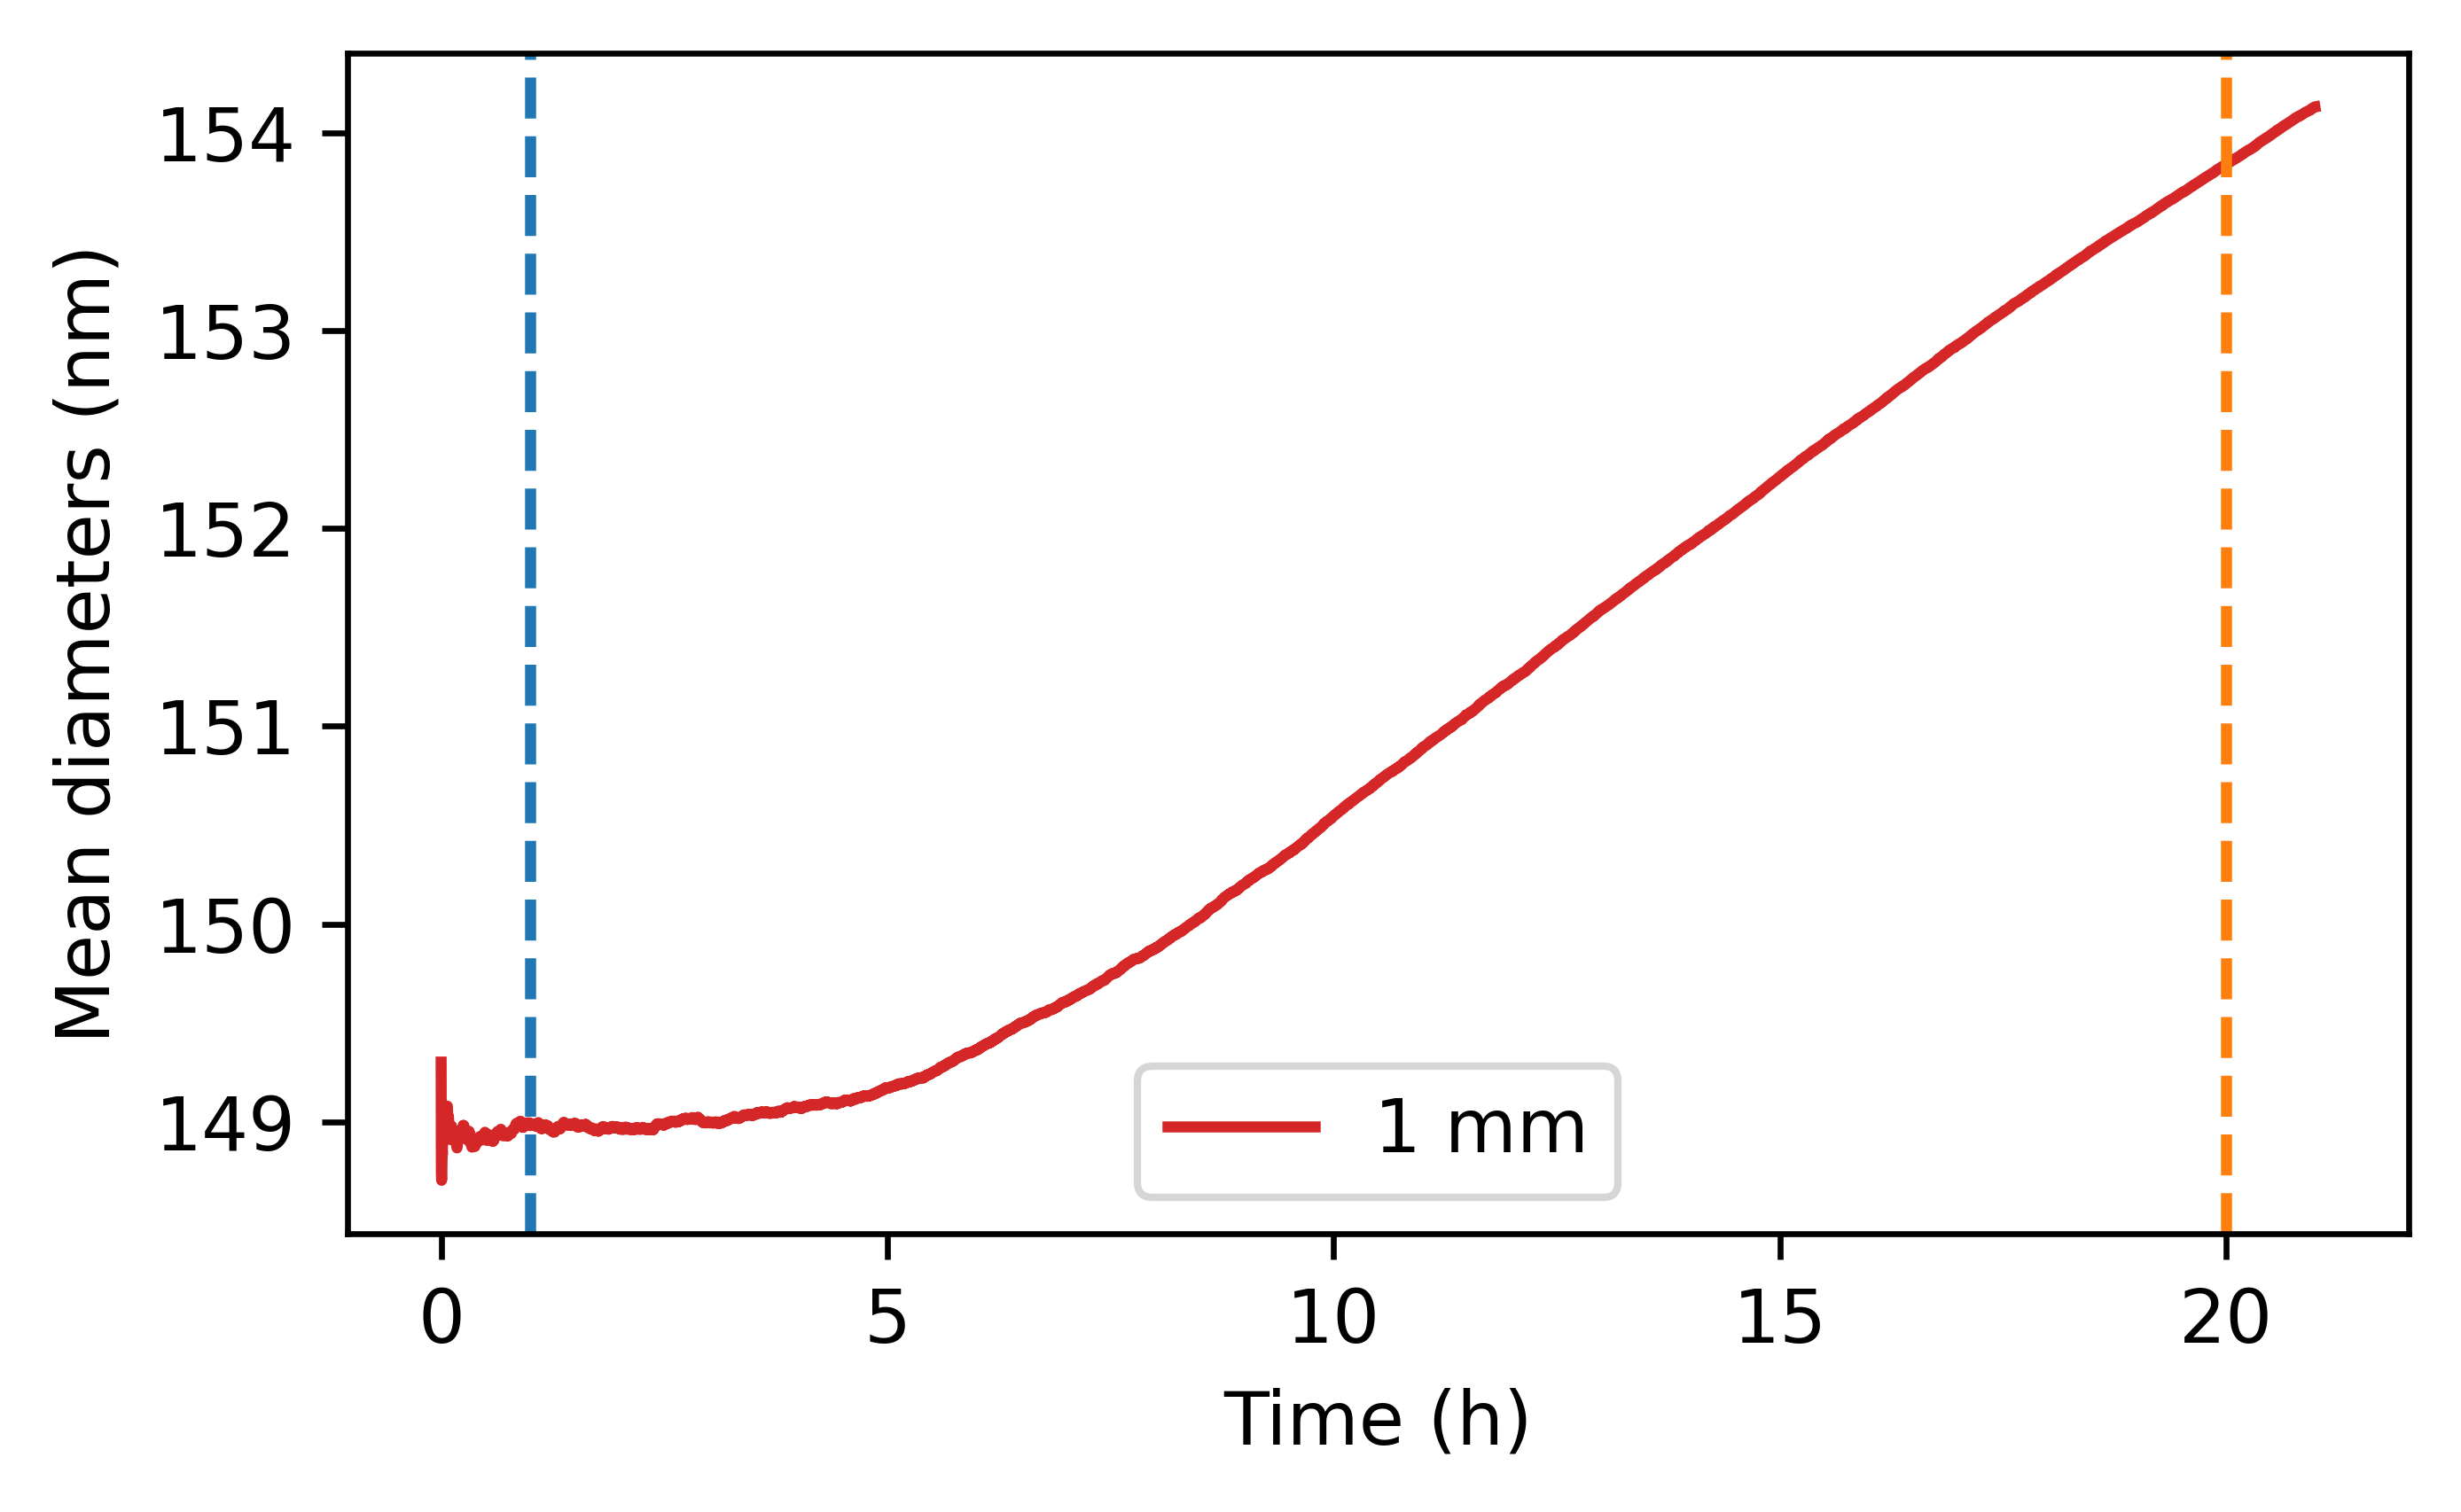

In [10]:
plt.figure(figsize=(5, 10), dpi=600)#fig, ax  =plt.subplots()
#fig, ax= plt.subplots()
plt.subplot(311)

plt.plot(t, mean_diam_in_t, label="1 mm", color='C3')
plt.axvline(1, color='C0', linestyle= "--")#, label="1 h")
plt.axvline(20, color = 'C1', linestyle="--")#, label = "20 h")

plt.legend()
plt.xlabel("Time (h)")
plt.ylabel("Mean diameters (nm)")

plt.show()

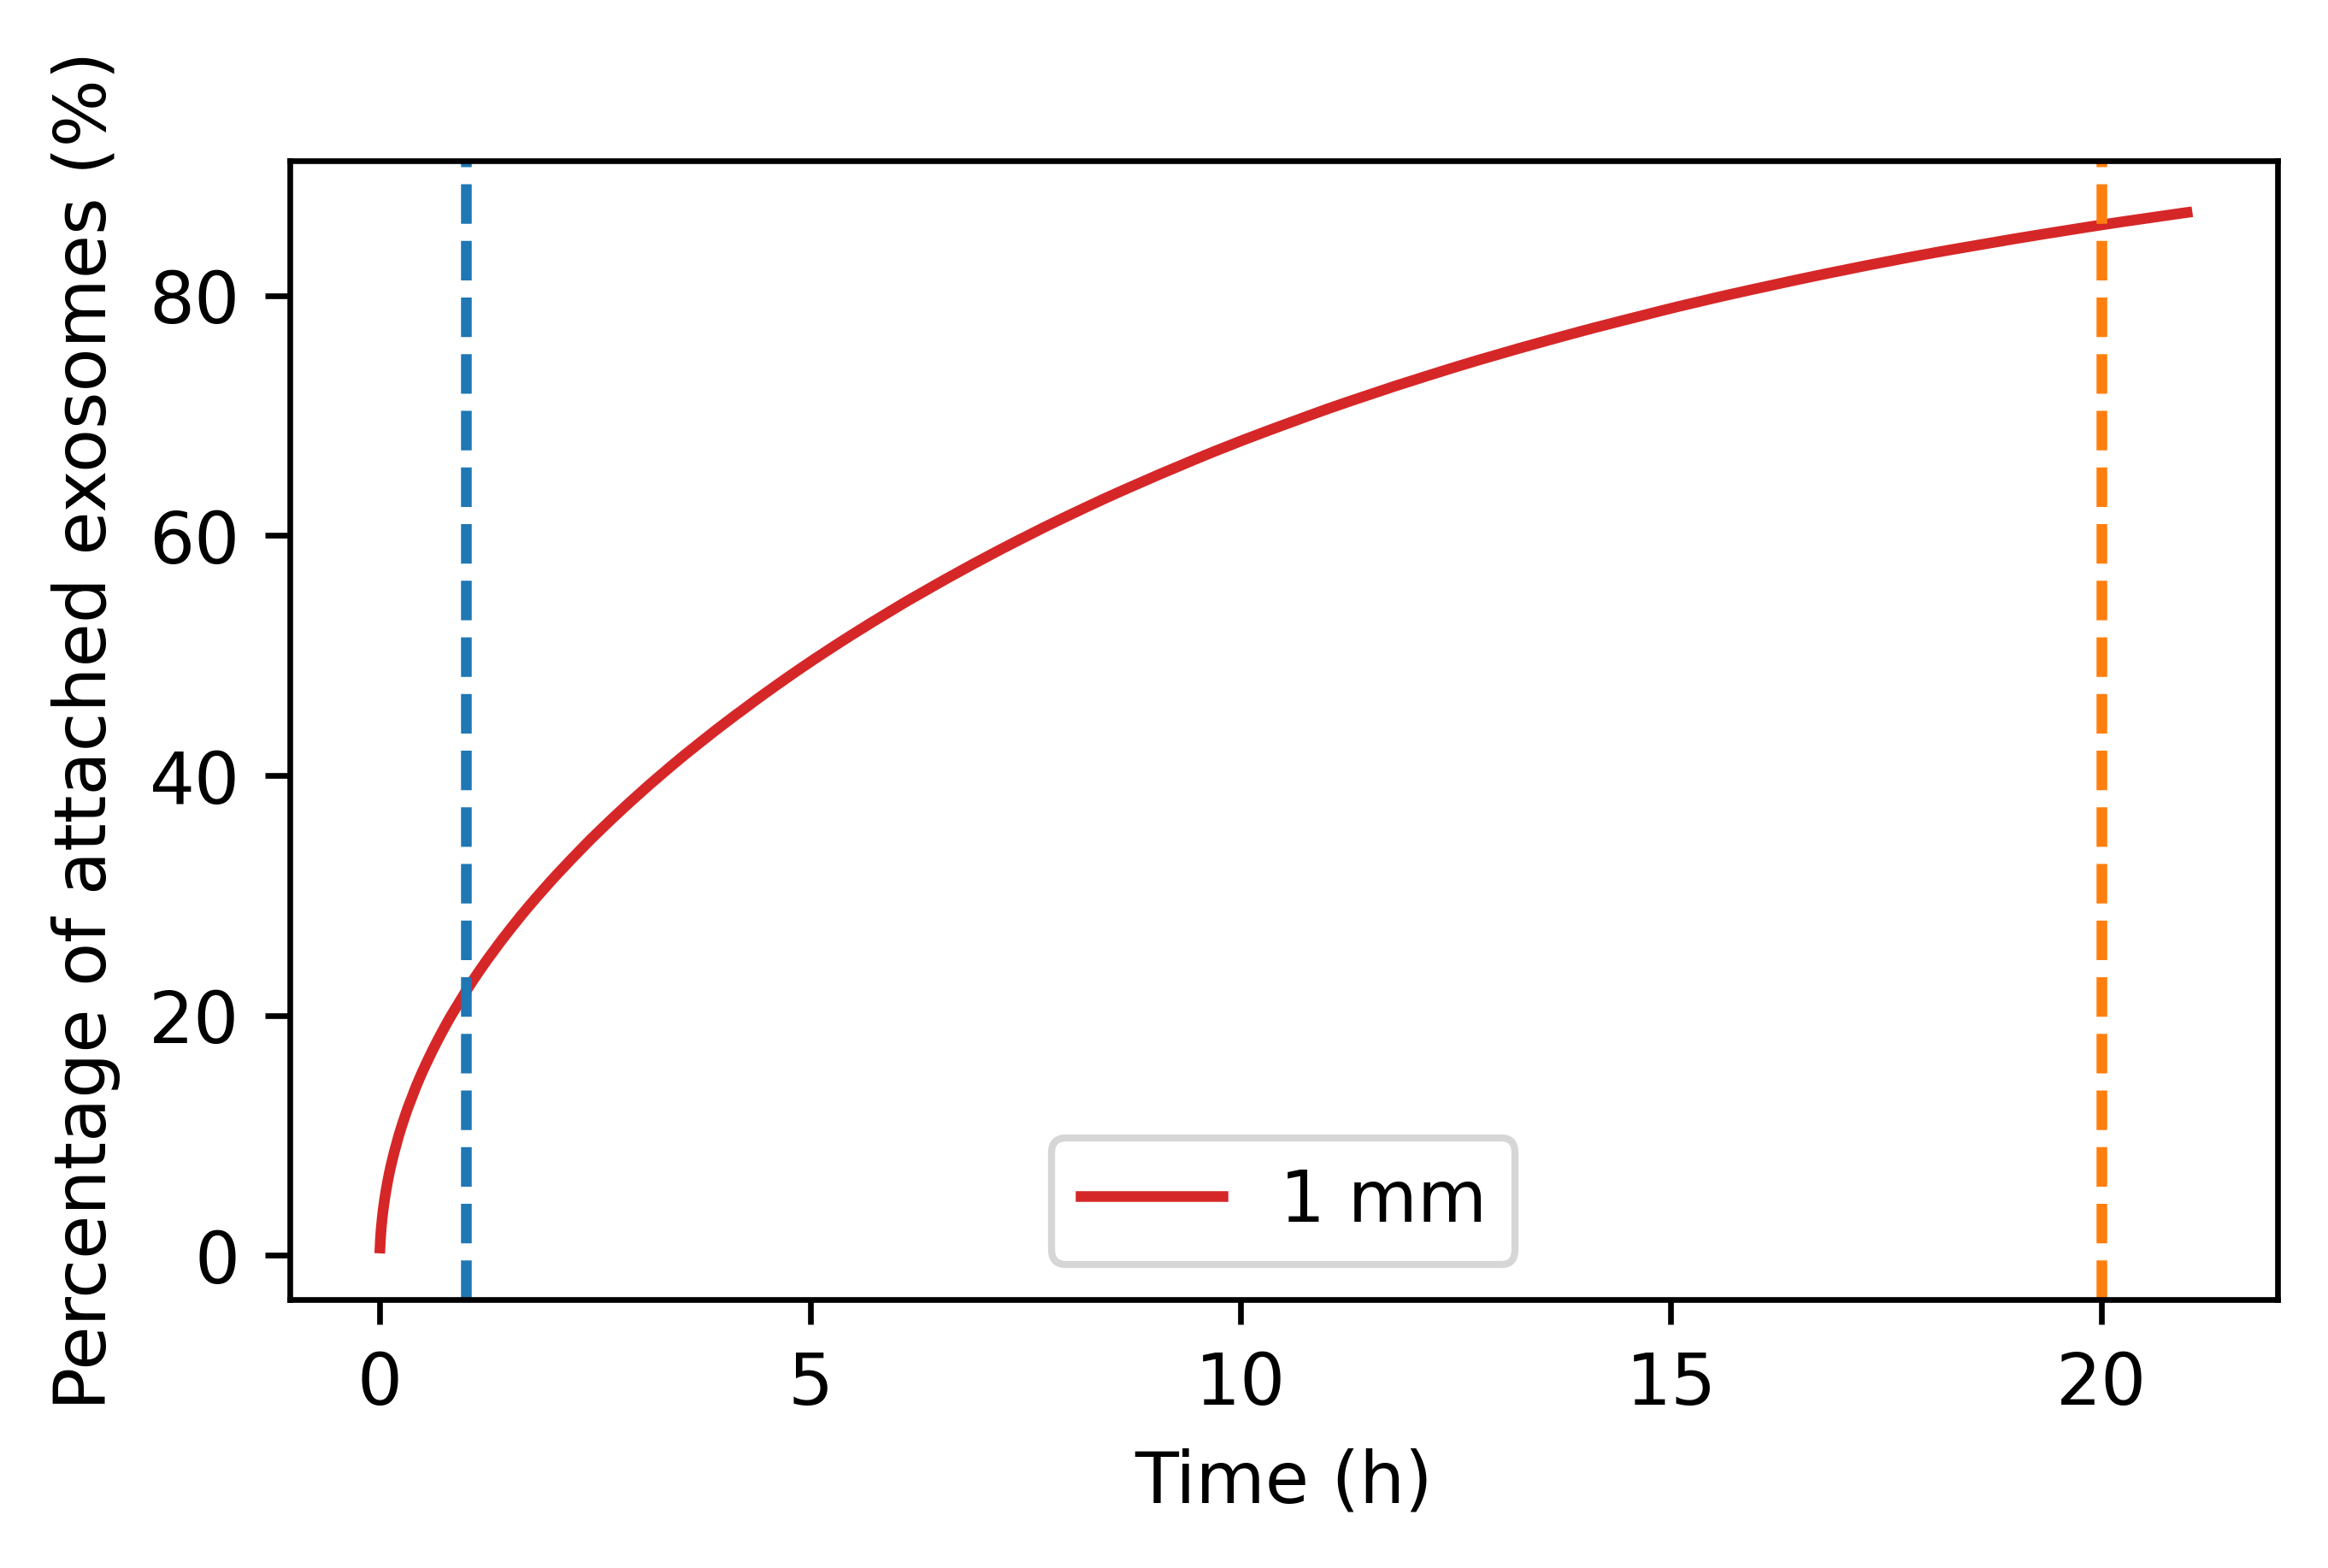

In [11]:
plt.figure(figsize=(5, 10), dpi=600)#fig, ax  =plt.subplots()
plt.subplot(311)
plt.plot(t, percent_attached, label="1 mm",color = 'C3' ) # color='red')
plt.axvline(1, color='C0', linestyle = "--")#, label="1 h")
plt.axvline(20, color = 'C1', linestyle = "--")#, label = "20 h")
plt.legend()
plt.xlabel("Time (h)")
plt.ylabel("Percentage of attached exosomes (%)")

plt.show()

# Calculation of the mean value of the drop height

Calculation of the mean value of the drop height with the base radius r and height h

Radius of the spherical bowl: $R=\frac{h^2+r^2}{2h}$

$h_{av}=\frac{\int_0^r\sqrt{R^2-x^2}\cdot 2\pi x dx}{\pi r^2}-(R-h)=$ ... compute indefinite integral

$=\frac 2 {r^2} (-\frac 1 3)(R^2-x^2)|_0^r-(R-h)=$ ... insert the limits of integration and R

$=\frac 1 2 h + \frac 1 6 \frac {h^3}{r^2}$

In [ ]:
a = 0.5E-2 #radius of the mica substrate in meters
h = 1E-3
h_av=(1/2)*h+(1/6)*(h**3/a**2) #average height value, approximately half the height
print(h_av)

0.0005066666666666667
